In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import time
import imutils
import numpy as np
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from os import listdir

%matplotlib inline

ModuleNotFoundError: No module named 'matplotlib'

Data Preprocessing & Preparation

In order to crop the part that contains only the brain of the img, I used a cropping technique to find the extreme top, bottom, left and right points of the brain.

In [2]:
def brain_contour(img, plot=False):
        
    # Converted img to grayscale, and blur slightly
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold img & perform erosions
    # dilations to remove small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Finding a contour in the thresholded img, then take a largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Finding extreme point
    extremLeft = tuple(c[c[:, :, 0].argmin()][0])
    extremRight = tuple(c[c[:, :, 0].argmax()][0])
    extremTop = tuple(c[c[:, :, 1].argmin()][0])
    extremBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # croped new img from original img by using four extreme point (top, bottom, right, left)
    new_img = img[extremTop[1]:extremBot[1], extremLeft[0]:extremRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(img)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Orignal Img')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_img)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Fine Img')
        
        plt.show()
    
    return new_img

In order to more understand what it's doing, let's take an img from the dataset and apply this cropping function to see the result:

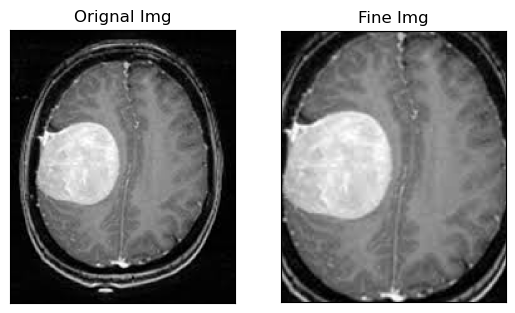

In [3]:
cont_img = cv2.imread('yes/Y1.jpg')
cont_img_new = brain_contour(cont_img, True)

#Loading data:

The function take 2 arguments,first one is list of dir path for folders 'yes' and 'no' that contain img data & second argument is img size, and for every img in both dir and follow: 
1. Read img.
2. Taking out part of the img representing only brain.
3. Resize the img (because img in the dataset come in differ size(meaning height & width & channel). So, we want all of our img to be (240, 240, 3) to put it as an input to the NN(Neural Network).
4. Applied normalization b/c we want pixel value scaled to range 0-1.
5. Append img to <i>X</i> and its label to <i>y</i>.<br>

After Shuffling <i>X</i> and <i>y</i>,the data is ordered (arrays contain first part belong to 1 class & 2 part belong to other class, & we don't want that).<br>
Finally, Return the <i>X</i> and <i>y</i>.

In [6]:
def data_loading(directorylist, img_size_on):
    """
    Read img & resize and normalize them. 
    Argument:
        dir_list: list of string represent file dir.
    Returns:
        X: array with shape = (exp, img_width, img_height, #_chanel)
        y: array with shape = (exp, 1)
    """

    # load every img in a dir
    img_width, img_height = img_size_on
    X = []
    y = []
    
    
    for dirt in directorylist:
        for f_name in listdir(dirt):
            # load img
            imageload = cv2.imread(dirt + '\\' + f_name)
            # crop brain and ignore rest part of img
            imageload = brain_contour(imageload, plot=False)
            # resize img
            imageload = cv2.resize(imageload, dsize=(img_width, img_height), interpolation=cv2.INTER_CUBIC)
            # normalize value
            imageload = imageload / 255.
            # convert img to array and append to X
            X.append(imageload)
            # append value of 1 to target arr if the img in folder named 'yes', otherwise append 0 in 'yes'.
            if dirt[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffledata
    X, y = shuffle(X, y)
    
    print(f'Number of the examples is that: {len(X)}')
    print(f'X having shapes is: {X.shape}')
    print(f'y having shapes is: {y.shape}')
    
    return X, y

Load the data augmented.
**Note:** Augmented data dir contains orignal as well as new generated image.

In [7]:
augmented_path = 'augmented data/'

# Augmented data dir contains orignal as well as new generated image exp.
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = data_loading([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of the examples is that: 2065
X having shapes is: (2065, 240, 240, 3)
y having shapes is: (2065, 1)


we have 2065 img. Every img have shape **(240, 240, 3)=(img_width, img_height, no_of_channel)**

**Ploting sample img:**

In [8]:
def sample_img(X, y, n=50):
    """
    Plot 50 sample img for both value of y(label).
    Argument:
        X: array with shape = (exp, img_width, img_height, #_channel)
        y: array with shape = (exp, 1)
    """
    
    for label in [0,1]:
        # take first n img with y value equal to label
        img = X[np.argwhere(y == label)]
        n_img = img[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_img:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

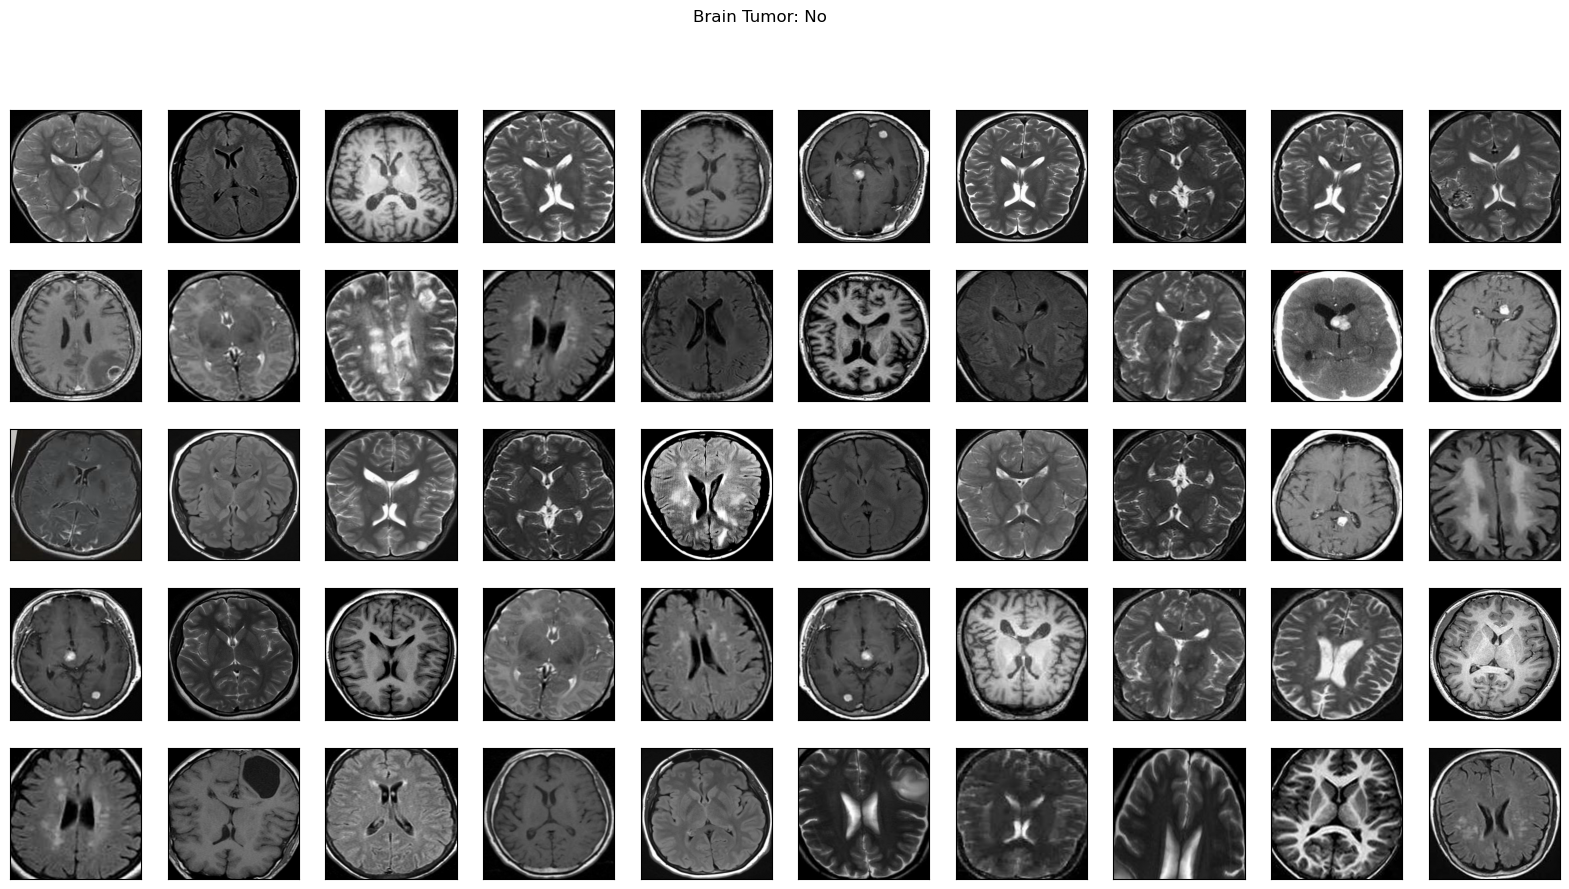

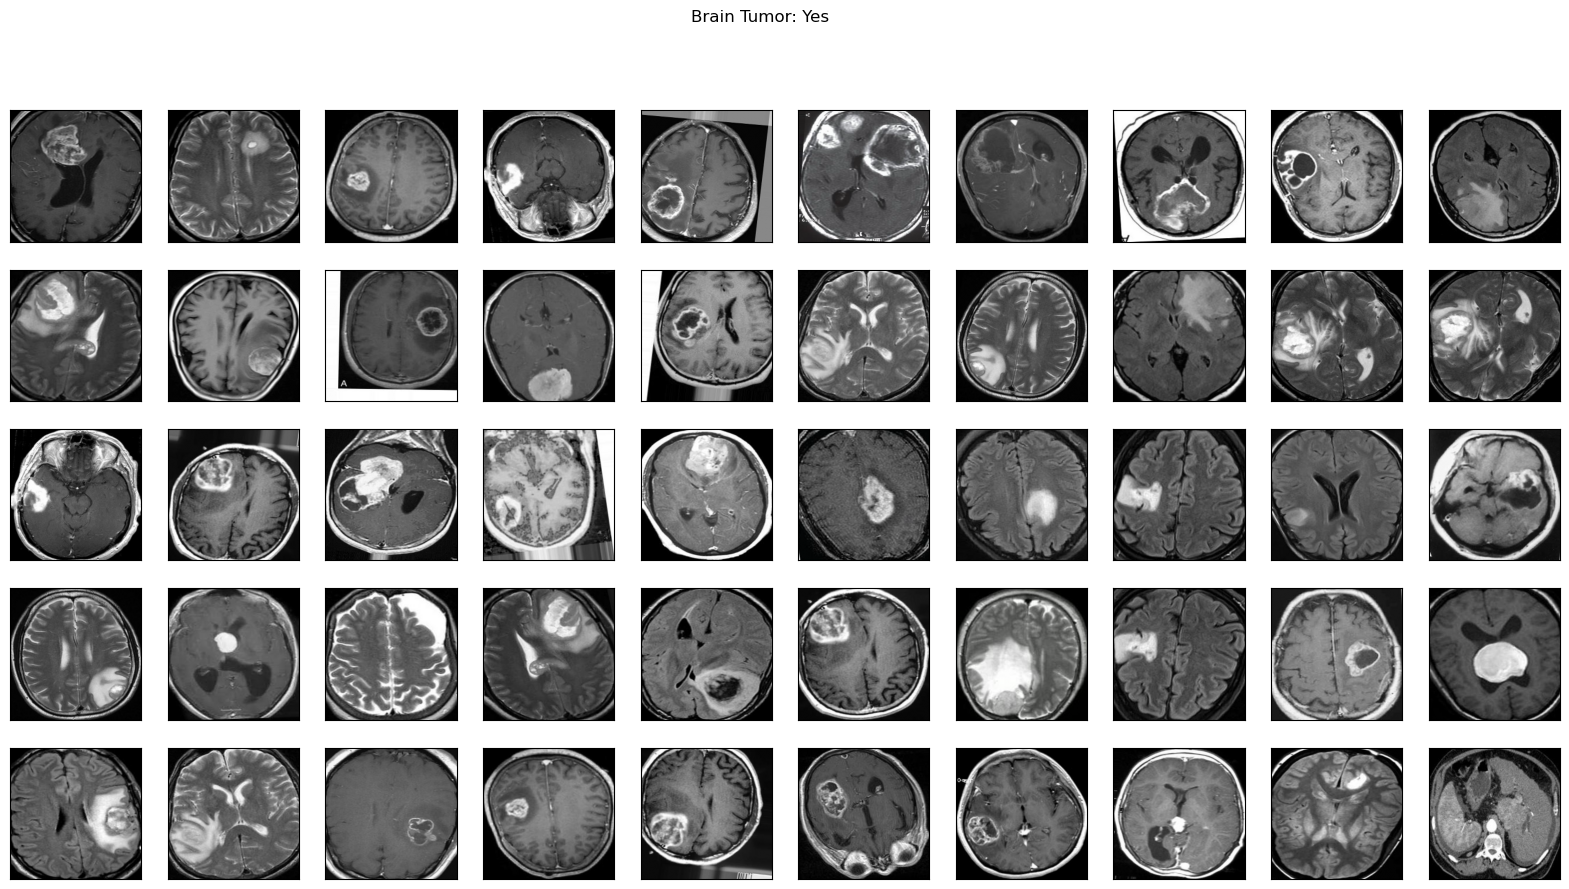

In [9]:
sample_img(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [10]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits the data in training, development and test.
    Argument:
        X: array in shape = (#_examples, image_width, image_height, #_channels)
        y: array in shape = (#_examples, 1)
    Returns:
        TraingX: Array with shape = (#_train_exp, image_width, image_height, #_channels)
        TrainingY: Array with shape = (#_train_exp, 1)
        Value_of_X: Array with shape = (#_val_exp, image_width, image_height, #_channels)
        Value_of_Y: Array with shape = (#_val_exp, 1)
        X_test: Array with shape = (#_test_exp, image_width, image_height, #_channels)
        test_of_Y: Array with shape = (#_test_exp, 1)
    """
    
    TraingX, X_test_val, TrainingY, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, Value_of_X, test_of_Y, Value_of_Y = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return TraingX, TrainingY, Value_of_X, Value_of_Y, X_test, test_of_Y

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [11]:
TraingX, TrainingY, Value_of_X, Value_of_Y, X_test, test_of_Y = split_data(X, y, test_size=0.3)

In [12]:
print ("number of training exp = " + str(TraingX.shape[0]))
print ("number of development exp = " + str(Value_of_X.shape[0]))
print ("number of test exp = " + str(X_test.shape[0]))
print ("TraingX shape: " + str(TraingX.shape))
print ("TrainingY shape: " + str(TrainingY.shape))
print ("Value_of_X (dev) shape: " + str(Value_of_X.shape))
print ("Value_of_Y (dev) shape: " + str(Value_of_Y.shape))
print ("X_test shape: " + str(X_test.shape))
print ("test_of_Y shape: " + str(test_of_Y.shape))

number of training exp = 1445
number of development exp = 310
number of test exp = 310
TraingX shape: (1445, 240, 240, 3)
TrainingY shape: (1445, 1)
Value_of_X (dev) shape: (310, 240, 240, 3)
Value_of_Y (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
test_of_Y shape: (310, 1)


Some helper functions:

In [13]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [14]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [15]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [16]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [17]:
model = build_model(IMG_SHAPE)

In [18]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

Compile the model:

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [21]:
# checkpoint
#the epoch and the validation..
filepath="cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"
# save model with best validation accuracy
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))
cd = [checkpoint]

## Train the model

In [22]:
start_time = time.time()

model.fit(x=TraingX, y=TrainingY, batch_size=32, epochs=10, validation_data=(Value_of_X, Value_of_Y))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 [==============================] - 41s 874ms/step - loss: 0.9088 - accuracy: 0.5952 - val_loss: 0.6901 - val_accuracy: 0.5226
Epoch 2/10
25/46 [===============>..............] - ETA: 17s - loss: 0.6153 - accuracy: 0.6775

KeyboardInterrupt: 

Let's train for a few more epochs:

In [ ]:
start_time = time.time()

model.fit(x=TraingX, y=TrainingY, batch_size=32, epochs=3, validation_data=(Value_of_X, Value_of_Y))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

In [ ]:
start_time = time.time()

model.fit(x=TraingX, y=TrainingY, batch_size=32, epochs=3, validation_data=(Value_of_X, Value_of_Y))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

In [ ]:
start_time = time.time()

model.fit(x=TraingX, y=TrainingY, batch_size=32, epochs=3, validation_data=(Value_of_X, Value_of_Y))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

In [ ]:
start_time = time.time()

model.fit(x=TraingX, y=TrainingY, batch_size=32, epochs=5, validation_data=(Value_of_X, Value_of_Y))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

In [ ]:
history = model.history.history

In [ ]:
for key in history.keys():
    print(key)

## Plot Loss & Accuracy

In [ ]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

**Note:** Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values. 

In [ ]:
plot_metrics(history) 

# Results

Let's experiment with the best model (the one with the best validation accuracy):

Concretely, the model at the 23rd iteration with validation accuracy of 91%

### Load the best model

In [ ]:
best_model = load_model(filepath='models/cnn-parameters-improvement-23-0.91.model')

In [ ]:
best_model.metrics_names

Evaluate the best model on the testing data:

In [ ]:
loss, acc = best_model.evaluate(x=X_test, y=test_of_Y)

### Accuracy of the best model on the testing data:

In [ ]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

### F1 score for the best model on the testing data:

In [ ]:
y_test_prob = best_model.predict(X_test)

In [ ]:
f1score = compute_f1_score(test_of_Y, y_test_prob)
print(f"F1 score: {f1score}")

Let's also find the f1 score on the validation data:

In [ ]:
y_val_prob = best_model.predict(Value_of_X)

In [ ]:
f1score_val = compute_f1_score(Value_of_Y, y_val_prob)
print(f"F1 score: {f1score_val}")

### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [ ]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [ ]:
# the whole data
data_percentage(y)

In [ ]:
print("Training Data:")
data_percentage(TrainingY)
print("Validation Data:")
data_percentage(Value_of_Y)
print("Testing Data:")
data_percentage(test_of_Y)

As expectred, the percentage of positive examples are around 50%.

# Conclusion:

#### Now, the model detects brain tumor with:<br>
**88.7%** accuracy on the **test set**.<br>
**0.88** f1 score on the **test set**.<br>
These resutls are very good considering that the data is balanced.

**Performance Table:**

| <!-- -->  | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  | 91%            | 89%      |
| F1 score  | 0.91           | 0.88     |

Hooray!

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
path = "C:\\Users\\Aditya Singh\\Downloads\\Project\\Brain-Tumor-Detection-master\\yes\\Y4.jpg"
img = load_img(path, target_size = (224,224))
input_arr = img_to_array(img)/255

plt.imshow(input_arr)
plt.show()

input_arr.shape

input_arr = np.expand_dims(input_arr, axis = 0)

pred = model.predict(input_arr)[0][0]
pred

if pred == 0:
    print("the mri have Brain Tumor")
else:
    print("the mri is not having a tumor")